Deep Convolutional Generative Adversarial Network
Generating Cloud Images with DCGAN
trained on V100

training start!
Epoch [10/300], D Loss: 0.5811, G Loss: 4.2236


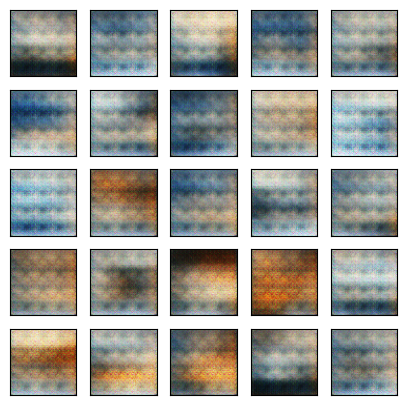

Epoch [20/300], D Loss: 0.4312, G Loss: 4.9994


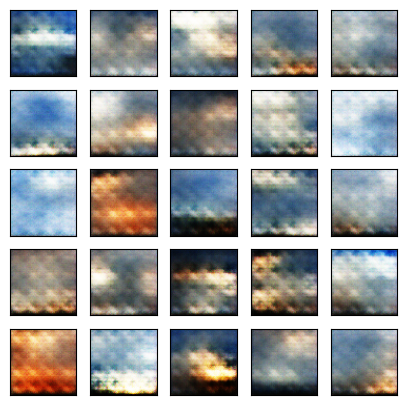

Epoch [30/300], D Loss: 0.4987, G Loss: 4.3610


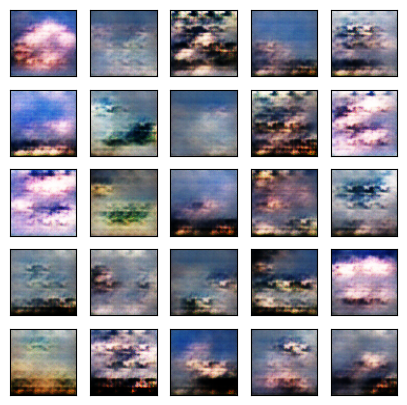

Epoch [40/300], D Loss: 0.5362, G Loss: 4.1642


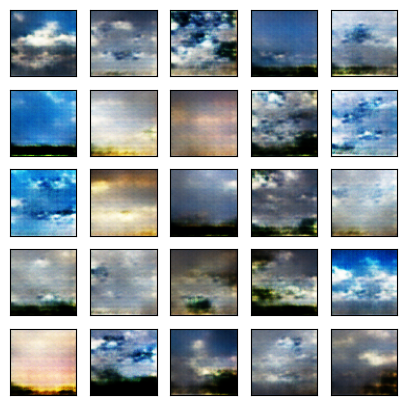

Epoch [50/300], D Loss: 0.3637, G Loss: 4.5788


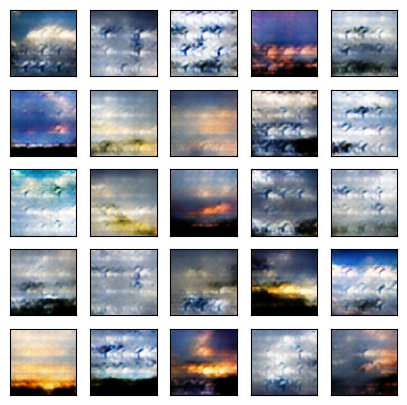

Epoch [60/300], D Loss: 0.4440, G Loss: 4.8807


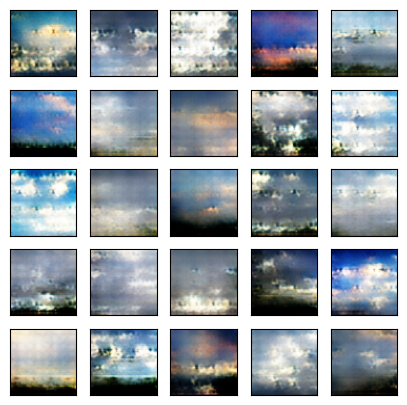

Epoch [70/300], D Loss: 0.3181, G Loss: 4.9173


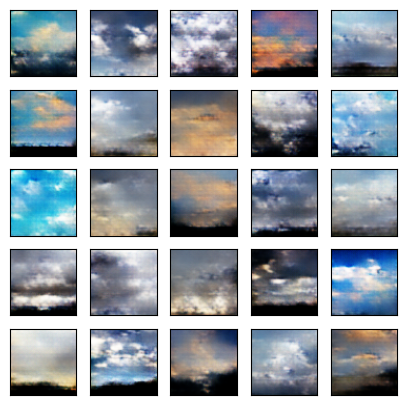

Epoch [80/300], D Loss: 0.2205, G Loss: 4.8994


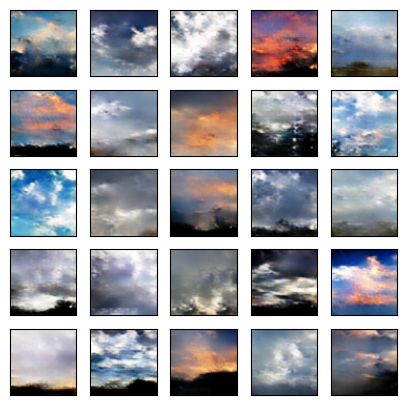

Epoch [90/300], D Loss: 0.2105, G Loss: 4.7781


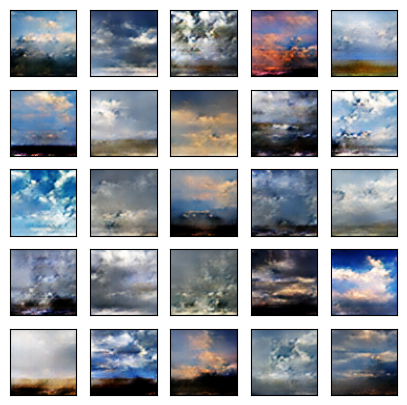

Epoch [100/300], D Loss: 0.1926, G Loss: 5.1497


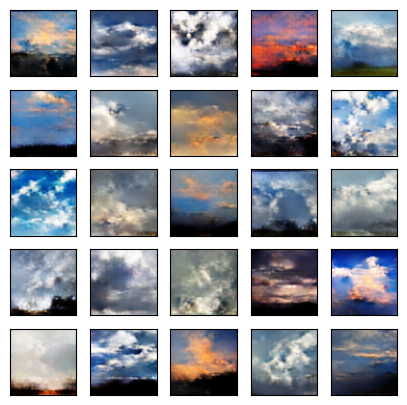

Epoch [110/300], D Loss: 0.0871, G Loss: 5.5498


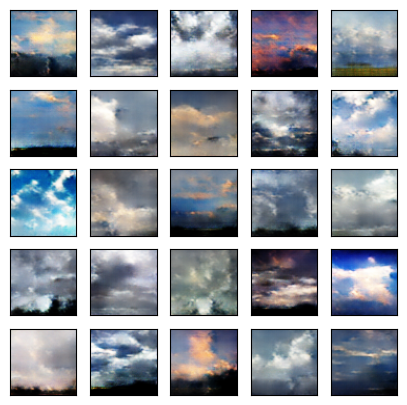

Epoch [120/300], D Loss: 0.0751, G Loss: 5.0958


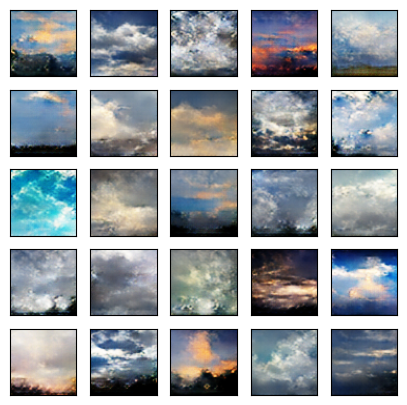

Epoch [130/300], D Loss: 0.1148, G Loss: 5.1317


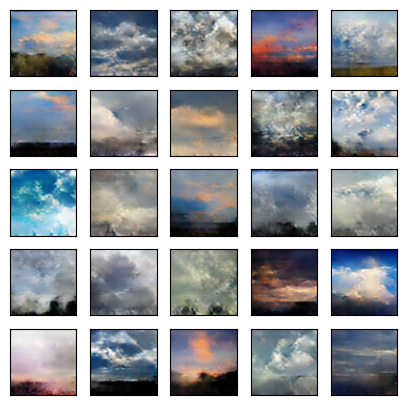

Epoch [140/300], D Loss: 0.0425, G Loss: 5.7250


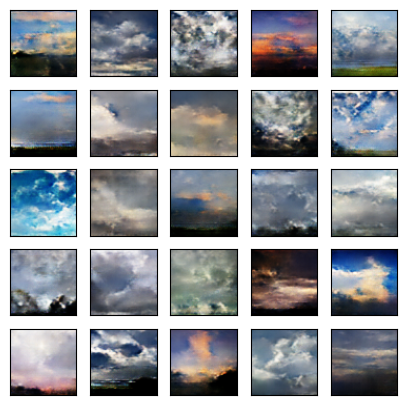

Epoch [150/300], D Loss: 0.1045, G Loss: 5.2222


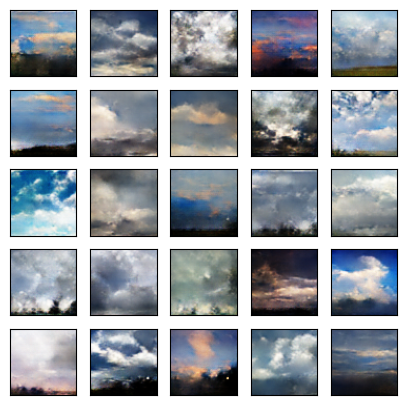

Epoch [160/300], D Loss: 0.3447, G Loss: 7.2058


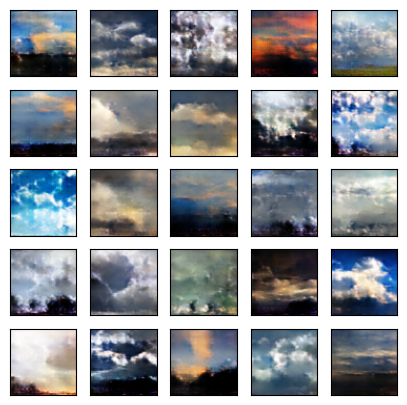

Epoch [170/300], D Loss: 0.0463, G Loss: 5.5043


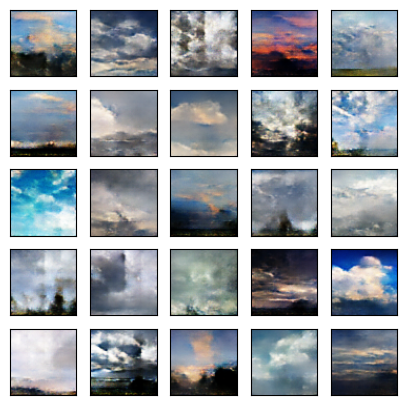

Epoch [180/300], D Loss: 0.1535, G Loss: 7.5960


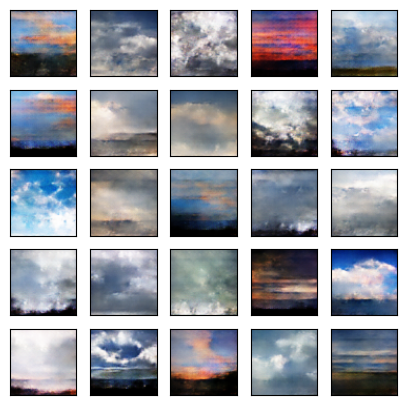

Epoch [190/300], D Loss: 0.0157, G Loss: 12.5085


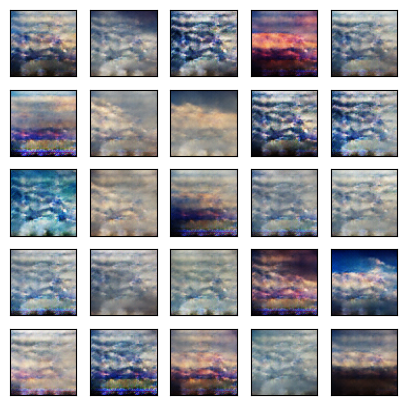

Epoch [200/300], D Loss: 0.6592, G Loss: 11.9094


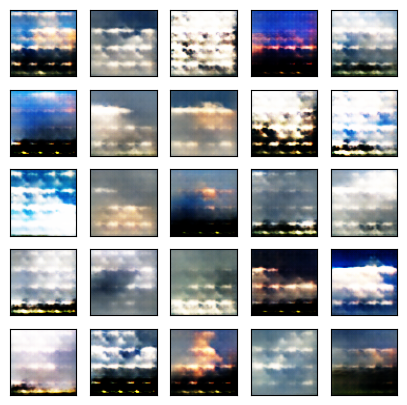

Epoch [210/300], D Loss: 0.0485, G Loss: 6.2631


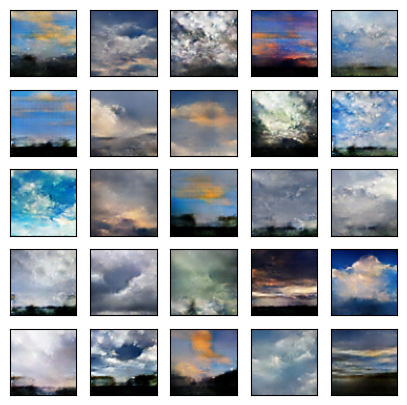

Epoch [220/300], D Loss: 0.0322, G Loss: 6.4898


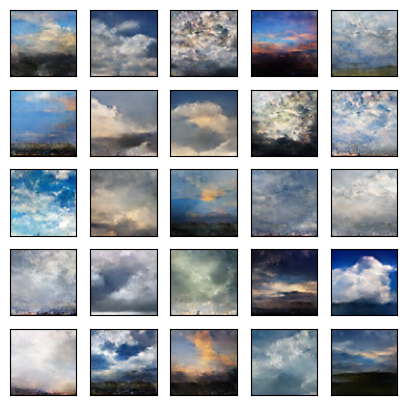

Epoch [230/300], D Loss: 0.0784, G Loss: 7.2724


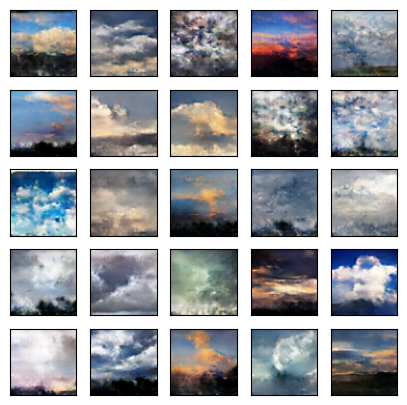

Epoch [240/300], D Loss: 0.0746, G Loss: 6.6399


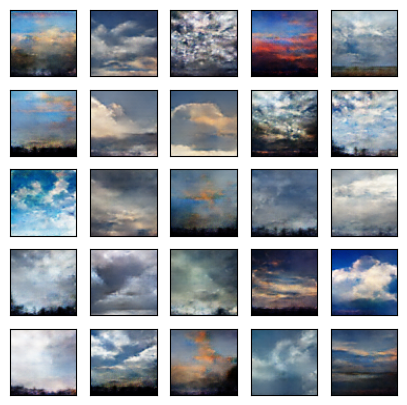

Epoch [250/300], D Loss: 0.0199, G Loss: 6.4699


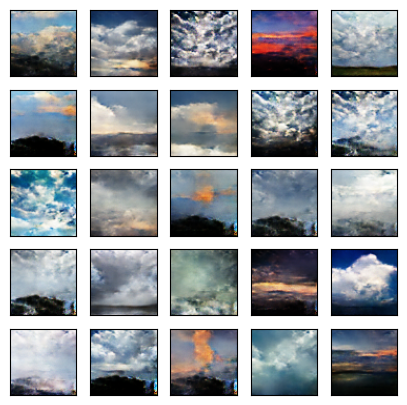

Epoch [260/300], D Loss: 0.0682, G Loss: 6.4557


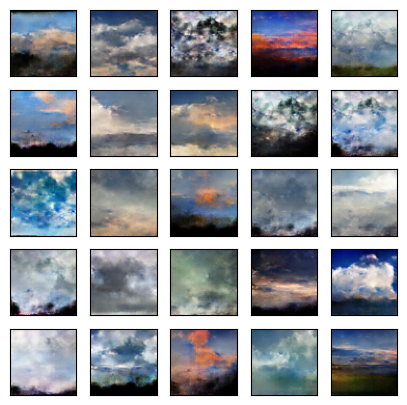

Epoch [270/300], D Loss: 0.0356, G Loss: 6.4649


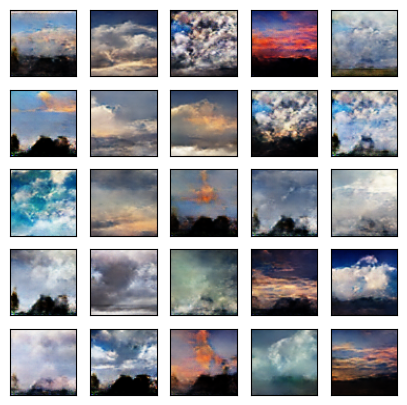

Epoch [280/300], D Loss: 0.0171, G Loss: 7.1046


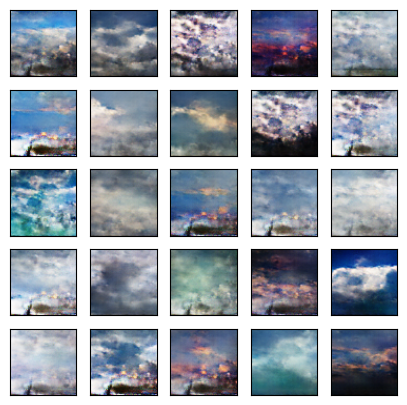

Epoch [290/300], D Loss: 0.0296, G Loss: 6.4206


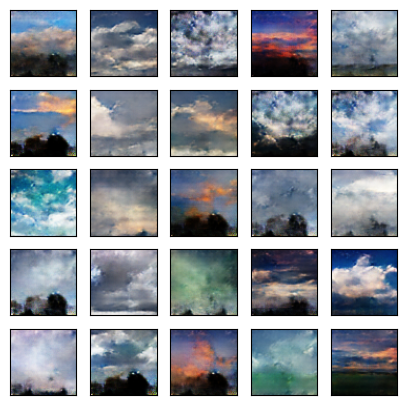

Epoch [300/300], D Loss: 0.0147, G Loss: 7.2167


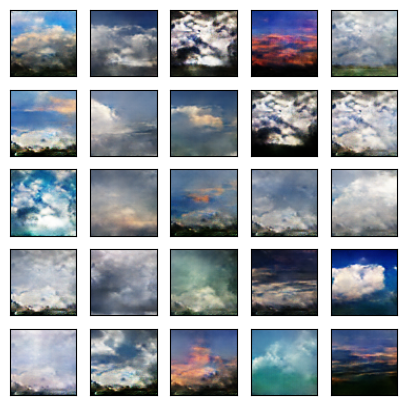

Total training time: 915.29s


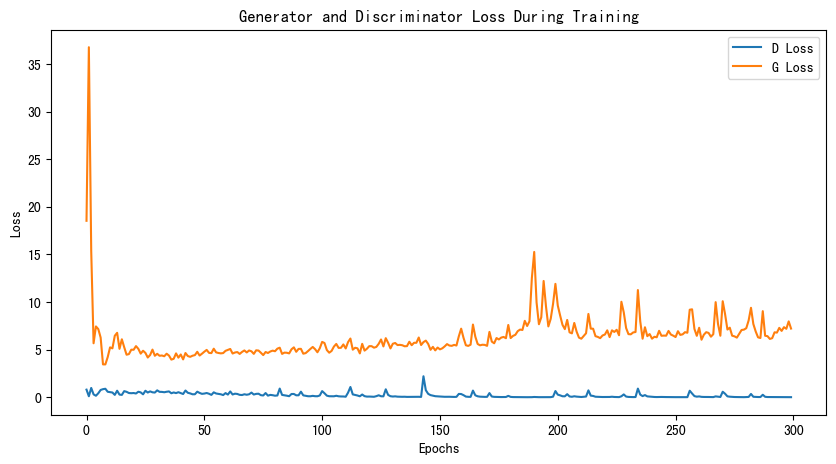

In [1]:
import os, time
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from PIL import Image
import matplotlib.pyplot as plt


class CloudDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if
                            f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


class generator(nn.Module):
    def __init__(self, d=128):
        super(generator, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d * 8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d * 8)
        self.deconv2 = nn.ConvTranspose2d(d * 8, d * 4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d * 4)
        self.deconv3 = nn.ConvTranspose2d(d * 4, d * 2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d * 2)
        self.deconv4 = nn.ConvTranspose2d(d * 2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = F.tanh(self.deconv5(x))
        return x


class discriminator(nn.Module):
    def __init__(self, d=128):
        super(discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d * 2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d * 2)
        self.conv3 = nn.Conv2d(d * 2, d * 4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d * 4)
        self.conv4 = nn.Conv2d(d * 4, d * 8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d * 8)
        self.conv5 = nn.Conv2d(d * 8, 1, 4, 1, 0)

    def weight_init(self, mean, std):
        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = F.sigmoid(self.conv5(x))
        return x


batch_size = 32
lr = 0.0001
train_epoch = 300


img_size = 64
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
root_dir = 'clouds'
cloud_dataset = CloudDataset(root_dir, transform=transform)
train_loader = DataLoader(cloud_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


G = generator(128).cuda()
D = discriminator(128).cuda()
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)

BCE_loss = nn.BCELoss().cuda()
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1).cuda()
D_losses = []
G_losses = []


print('training start!')
start_time = time.time()
for epoch in range(train_epoch):
    D_epoch_losses = []
    G_epoch_losses = []
    for x_ in train_loader:

        D.zero_grad()
        mini_batch = x_.size()[0]
        y_real_ = torch.ones(mini_batch).cuda()
        y_fake_ = torch.zeros(mini_batch).cuda()
        x_ = Variable(x_.cuda())
        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result, y_real_)
        
        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)
        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()
        D_epoch_losses.append(D_train_loss.item())

        G.zero_grad()
        z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z_)
        D_result = D(G_result).squeeze()
        G_train_loss = BCE_loss(D_result, y_real_)
        G_train_loss.backward()
        G_optimizer.step()
        G_epoch_losses.append(G_train_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{train_epoch}], D Loss: {torch.mean(torch.FloatTensor(D_epoch_losses)):.4f}, G Loss: {torch.mean(torch.FloatTensor(G_epoch_losses)):.4f}')
        with torch.no_grad():
            G.eval()
            test_images = G(fixed_z_)
            G.train()

            test_images = (test_images + 1) / 2  
            test_images = torch.clamp(test_images, 0, 1)  
            size_figure_grid = 5
            fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
            for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)
            for k in range(5 * 5):
                i = k // 5
                j = k % 5
                ax[i, j].cla()
                ax[i, j].imshow(test_images[k].permute(1, 2, 0).cpu().numpy())
            plt.show()

    D_losses.append(torch.mean(torch.FloatTensor(D_epoch_losses)).item())
    G_losses.append(torch.mean(torch.FloatTensor(G_epoch_losses)).item())

end_time = time.time()
print(f"Total training time: {end_time - start_time:.2f}s")

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(D_losses, label="D Loss")
plt.plot(G_losses, label="G Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

It was observed that the G loss increased in the later stages of training, and the quality of the generated images suddenly deteriorated at 200 epochs. This might be due to a fixed learning rate. In the next training attempt, a learning rate decay strategy will be tried.